In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Load the data
genotypes = pd.read_csv('tomatoes/Genotypic_data_maf10_min10_291acc.txt', index_col=0)
phenotype = pd.read_csv('tomatoes/phenodata_BLUP_2012.txt', sep='\t', index_col='ID')

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    genotypes, phenotype['FREAR'], test_size=0.2, random_state=42)

In [4]:
# Function to calculate minor allele frequency
def calculate_maf(df):
    maf = df.apply(lambda x: min(x.mean(), 1 - x.mean()), axis=0)
    return maf

# Function for LD pruning
def ld_pruning(df, threshold=0.5):
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # Updated to use bool
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(to_drop, axis=1)

In [5]:
# Apply MAF and LD pruning only to the training set
maf = calculate_maf(X_train)
X_train_filtered = X_train.loc[:, maf > 0.05]  # Filter out SNPs with MAF <= 5%
X_train_pruned = ld_pruning(X_train_filtered)

In [6]:
# Impute missing data and scale the data
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_pruned), columns=X_train_pruned.columns)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_pruned.columns)

# Apply the same imputation and scaling transformations to the test set
X_test_filtered = X_test[X_train_pruned.columns]  # Keep only the columns that survived pruning
X_test_imputed = pd.DataFrame(imputer.transform(X_test_filtered), columns=X_train_pruned.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_train_pruned.columns)


In [7]:
# Random Forest hyperparameters grid for Randomized Search CV
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
}

# Randomized search with cross-validation using RandomForestRegressor
rf_random_search = RandomizedSearchCV(RandomForestRegressor(random_state=0),
                                      rf_params, n_iter=10, cv=5, verbose=2, random_state=0)
rf_random_search.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.2s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.2s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.2s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.2s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.2s
[CV] END .....................max_depth=30, n_estimators=300; total time=   0.8s
[CV] END .....................max_depth=30, n_estimators=300; total time=   0.8s
[CV] END .....................max_depth=30, n_estimators=300; total time=   0.8s
[CV] END .....................max_depth=30, n_estimators=300; total time=   0.8s
[CV] END .....................max_depth=30, n_estimators=300; total time=   0.8s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=10, n_es

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'n_estimators': [100, 200, 300]},
                   random_state=0, verbose=2)

In [8]:
# Extracting best estimator and its features
best_rf = rf_random_search.best_estimator_
selected_features = X_train_scaled.columns[best_rf.feature_importances_ > np.percentile(best_rf.feature_importances_, 75)]

In [9]:
# Export selected features
pd.Series(selected_features).to_csv('Features_selected/selected_features_random_forest.csv', index=False)

In [10]:
# Using selected features for modeling
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

In [11]:
X_train_selected.head()

,IIT12528,IIT12147,IIT11292,solcap_snp_sl_60078,solcap_snp_sl_33676,solcap_snp_sl_59771,solcap_snp_sl_50539,solcap_snp_sl_16331,IIT11440,IIT9961,...,solcap_snp_sl_55518,solcap_snp_sl_7025,solcap_snp_sl_15381,solcap_snp_sl_10190,IIT7761,solcap_snp_sl_17547,IIT9900,solcap_snp_sl_9790,IIT9983,solcap_snp_sl_31975
0,-1.015593,-0.615328,-0.586011,2.659013,1.971164,-0.430445,0.076029,-0.530954,-0.504187,1.674410,...,-0.715661,1.310053,-0.561041,2.081705,2.333333,-0.976803,-0.547498,-0.451359,-0.43914,-0.415339
1,1.024386,-0.615328,-0.586011,-0.387362,-0.527798,-0.430445,0.076029,1.932674,0.767241,-0.610667,...,1.543296,-0.815348,-0.561041,-0.487208,-0.428571,-0.976803,1.849099,-0.451359,-0.43914,-0.415339
2,1.024386,-0.615328,-0.586011,-0.387362,1.971164,-0.430445,0.076029,1.932674,2.038670,-0.610667,...,1.543296,-0.815348,1.849357,-0.487208,-0.428571,-0.976803,-0.547498,-0.451359,-0.43914,-0.415339
3,1.024386,-0.615328,-0.586011,-0.387362,-0.527798,-0.430445,0.076029,1.932674,-0.504187,1.674410,...,-0.715661,1.310053,-0.561041,2.081705,-0.428571,1.055648,1.849099,-0.451359,-0.43914,2.595871
4,-1.015593,-0.615328,-0.586011,-0.387362,-0.527798,-0.430445,2.280858,-0.530954,-0.504187,-0.610667,...,-0.715661,1.310053,-0.561041,-0.487208,-0.428571,-0.976803,-0.547498,-0.451359,-0.43914,-0.415339


In [12]:
# Linear regression with cross-validation
regressor = LinearRegression()
cv_scores = cross_val_score(regressor, X_train_selected, y_train, cv=5, scoring='neg_mean_squared_error')
regressor.fit(X_train_selected, y_train)
y_pred = regressor.predict(X_test_selected)


In [13]:
# Calculate RMSE and R-squared
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mean_cv_rmse = np.sqrt(-cv_scores.mean())

print(f'Test RMSE: {rmse}')
print(f'Test R²: {r2}')
print(f'Cross-Validated RMSE: {mean_cv_rmse}')


Test RMSE: 2.1685824665879996
Test R²: 0.33580323097887044
Cross-Validated RMSE: 2.3072873857687157


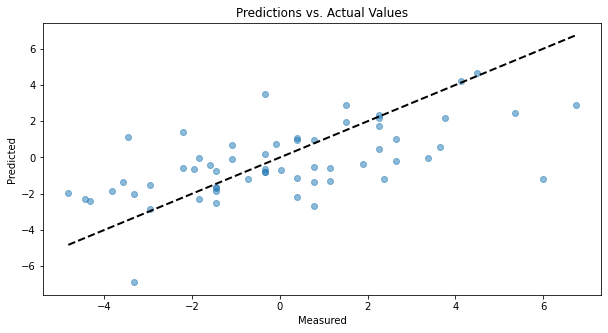

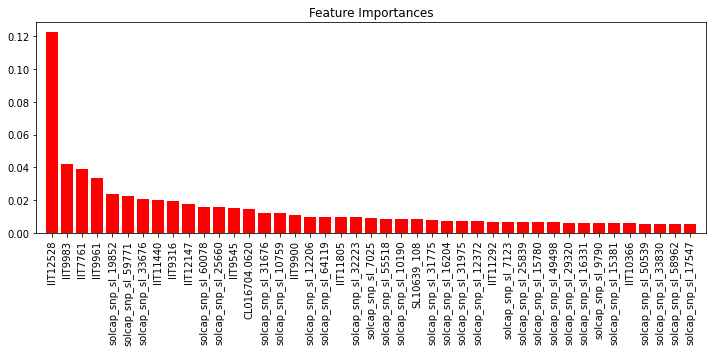

In [14]:
# Visualization of predictions vs. actual
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predictions vs. Actual Values')
plt.show()

# Assuming 'best_rf' is your trained RandomForestRegressor model
importances = best_rf.feature_importances_
# Extract the indices of the selected features from the full feature set
selected_indices = [list(X_train_scaled.columns).index(feature) for feature in selected_features]

# Filter the importances to only those that are selected
selected_importances = importances[selected_indices]

# Get the sorted indices of the selected importances
sorted_indices = np.argsort(selected_importances)[::-1]

# Plotting
plt.figure(figsize=(10, 5))
plt.title('Feature Importances')
plt.bar(range(len(selected_features)), selected_importances[sorted_indices], color="r", align="center")
plt.xticks(range(len(selected_features)), np.array(selected_features)[sorted_indices], rotation=90)
plt.xlim([-1, len(selected_features)])
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()
